In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader, TensorDataset
import math
import matplotlib.pyplot as plt
import numpy as np
import ast
import shutil
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score

In [2]:
data = pd.read_csv("fraud.csv")
data = data.dropna()
data.reset_index(drop=True)
half = len(data)//2
data = data[:half]


In [3]:
X = data['Email Info']
y = data['Class']

In [4]:
x_train, x_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size = 0.20)
x_test, X_valid, y_test, y_valid = train_test_split(x_test_valid, y_test_valid, test_size=0.5, random_state=42)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
cv.fit(data['Email Info'])
x_train = cv.transform(x_train)
x_test = cv.transform(x_test)
x_valid = cv.transform(X_valid)
print(x_test.shape)
x_train.shape

(894, 90954)


(7152, 90954)

In [6]:
#https://medium.com/analytics-vidhya/part-1-sentiment-analysis-in-pytorch-82b35edb40b8
X_train_tensor = torch.from_numpy(x_train.todense()).float()
X_test_tensor = torch.from_numpy(x_test.todense()).float()
X_valid_tensor = torch.from_numpy(x_valid.todense()).float()
Y_train_tensor = torch.from_numpy(np.array(y_train))
Y_test_tensor = torch.from_numpy(np.array(y_test))
Y_valid_tensor = torch.from_numpy(np.array(y_valid))

In [7]:
train_data = TensorDataset(X_train_tensor, Y_train_tensor)
test_data = TensorDataset(X_test_tensor, Y_test_tensor)
valid_data = TensorDataset(X_valid_tensor, Y_valid_tensor)

In [8]:
train_loader = DataLoader(train_data,batch_size=16, shuffle=True,drop_last=True, num_workers=0)
valid_loader = DataLoader(train_data,batch_size=16, shuffle=True,drop_last=True, num_workers=0)
test_loader = DataLoader(train_data,batch_size=16, shuffle=True,drop_last=True, num_workers=0)

In [9]:
vocab_size = 90954
hidden_units = 3
out_classes = 1
class model(torch.nn.Module):
    def __init__(self,vocab_size = vocab_size,hidden_units = hidden_units,num_classes = out_classes): 
      super(model, self).__init__()
      #First fully connected layer
      self.fc1 = torch.nn.Linear(vocab_size,hidden_units)
      #Second fully connected layer
      self.fc2 = torch.nn.Linear(hidden_units,num_classes)
      #Final output of sigmoid function      
      self.output = torch.nn.Sigmoid()
    
    def forward(self,x):
          fc1 = self.fc1(x)
          fc2 = self.fc2(fc1)
          # y_pred = torch.nn.sigmoid(fc1)
          # return y_pred
          output = self.output(fc2)
          return output[:, -1]

model = model()

In [10]:
model.train()

model(
  (fc1): Linear(in_features=90954, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
  (output): Sigmoid()
)

In [11]:
num_epochs = 20

LEARNING_RATE = 0.001


In [12]:
optimizer =torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCELoss()


In [14]:
#https://github.com/vedaant-varshney/ImageClassifierCNN/blob/master/Image%20Classifier.ipynb
# os.chdir('/Users/king.botti/Documents/CS488/models')
n_total_steps = len(train_loader)
# tracks validation loss change after each epoch
minimum_validation_loss = np.inf 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train_loss = 0
        valid_loss = 0

        images = images
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # train_loss += loss.item()*data.size(0)
    model.eval()
    for batch_index, (data, target) in enumerate(valid_loader):
        # moves tensors to GPU
        data, target = data, target
        # forward pass
        output = model(data)
        # loss in batch
        loss = criterion(output, target.float())
        # update validation loss
        valid_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    if (i+1) % 2000 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    if valid_loss <= minimum_validation_loss:
        print(f'Validation loss decreased from {round(minimum_validation_loss, 6)} to {round(valid_loss, 6)}')
        torch.save(model.state_dict(), 'trained_model_nn.pt')
        minimum_validation_loss = valid_loss
        print('Saving New Model')

Validation loss decreased from inf to 0.461237
Saving New Model
Validation loss decreased from 0.461237 to 0.405326
Saving New Model
Validation loss decreased from 0.405326 to 0.366029
Saving New Model
Validation loss decreased from 0.366029 to 0.333786
Saving New Model
Validation loss decreased from 0.333786 to 0.306463
Saving New Model
Validation loss decreased from 0.306463 to 0.282947
Saving New Model
Validation loss decreased from 0.282947 to 0.262725
Saving New Model
Validation loss decreased from 0.262725 to 0.245209
Saving New Model
Validation loss decreased from 0.245209 to 0.230062
Saving New Model
Validation loss decreased from 0.230062 to 0.217002
Saving New Model
Validation loss decreased from 0.217002 to 0.205488
Saving New Model
Validation loss decreased from 0.205488 to 0.195523
Saving New Model
Validation loss decreased from 0.195523 to 0.186818
Saving New Model
Validation loss decreased from 0.186818 to 0.179098
Saving New Model
Validation loss decreased from 0.179098

In [13]:
model.load_state_dict(torch.load('trained_model_nn.pt'))
model.eval()

model(
  (fc1): Linear(in_features=90954, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
  (output): Sigmoid()
)

In [20]:
batch_size = 16
with torch.no_grad():
    y_pred = []
    y_test = []
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_loader:
        images = images
        labels = labels
        print(images)
        break
        outputs = model(images)
        predicted = torch.round(outputs)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            y_pred.append(int(pred))
            y_test.append(int(label))
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy equals: {acc} %')

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


ZeroDivisionError: float division by zero

In [15]:
ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
pr = precision_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')
re = recall_score(y_test, y_pred,average='weighted')

print("Accuracy is :",ac)
print("precision is :",pr)
print("f-1 score is :",f1)
print("recall score is:", re)

Accuracy is : 0.9566554809843401
precision is : 0.9595550465666469
f-1 score is : 0.9563182049433975
recall score is: 0.9566554809843401


In [16]:
cm

array([[4059,    4],
       [ 306, 2783]])

In [17]:
columns = {"Fraud":1,"Actual":0}

In [18]:
cm_df = pd.DataFrame(cm,
                     index = columns, 
                     columns = columns)

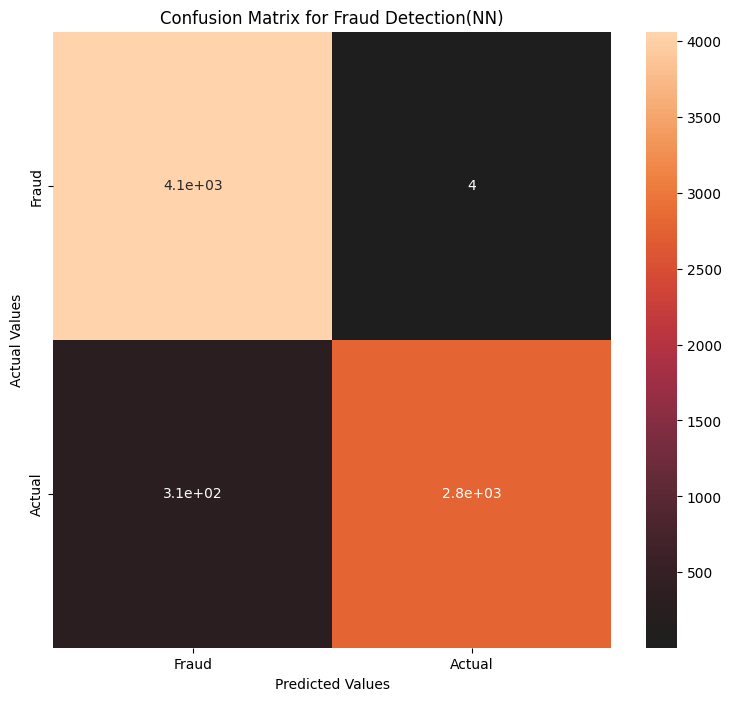

In [19]:
plt.figure(figsize=(9, 8))
sns.heatmap(cm_df, annot=True, center=1)
plt.title('Confusion Matrix for Fraud Detection(NN)')
# plt.colorbar()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig('Confusion Matrix Fraud Detection NN')
file = os.getcwd() + "//Confusion Matrix fraud NN.png"
plt.show()

In [69]:
def predict():
    text = input()
    x = cv.transform([text]).toarray()
    x = torch.from_numpy(x).float()
    predict = model(x)
    # print(predict)
    chances = round(float(predict) * 100,2)
    predict = torch.round(predict)
    columns = {1:"Fraud",0:"Actual Email"}
    # print(columns[int(predict)])
    new_line = '\n'
    print(f'{new_line}This email has a {chances}% chance of being a Fraud {new_line}{new_line}It is predicted as {columns[int(predict)]}')
    return 
predict()

 Use this link to change your password



This email has a 25.47% chance of being a Fraud 

It is predicted as Actual Email
